In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from gsfit import Gsfit
from scipy import interpolate
from st40_database import GetData

In [2]:
pulseNo_real = 12050
pulseNo_read = pulseNo_real + 13_000_000
pulseNo_write = pulseNo_real + 11_000_000

controller_inverse = Gsfit(
    pulseNo=pulseNo_read,
    run_name="RUN202",
    pulseNo_write=pulseNo_write,
    run_description="Reconstructing ASTRA#RUN220",
    write_to_mds=True,
    settings_path="st40_with_synthetic_data_from_astra",
)

controller_inverse.run()

2025-05-25 08:35:14  |  GSFIT  |  diagnostics_analysis_base.py:166     |  INFO  |  Loading settings from: "GSFIT_code_settings.json"
2025-05-25 08:35:14  |  GSFIT  |  diagnostics_analysis_base.py:166     |  INFO  |  Loading settings from: "passive_dof_regularisation.json"
2025-05-25 08:35:14  |  GSFIT  |  diagnostics_analysis_base.py:166     |  INFO  |  Loading settings from: "sensor_weights_bp_probe.json"
2025-05-25 08:35:14  |  GSFIT  |  diagnostics_analysis_base.py:166     |  INFO  |  Loading settings from: "sensor_weights_dialoop.json"
2025-05-25 08:35:14  |  GSFIT  |  diagnostics_analysis_base.py:166     |  INFO  |  Loading settings from: "sensor_weights_flux_loops.json"
2025-05-25 08:35:14  |  GSFIT  |  diagnostics_analysis_base.py:166     |  INFO  |  Loading settings from: "sensor_weights_isoflux.json"
2025-05-25 08:35:14  |  GSFIT  |  diagnostics_analysis_base.py:166     |  INFO  |  Loading settings from: "sensor_weights_pressure.json"
2025-05-25 08:35:14  |  GSFIT  |  diagnost

TreeNNF: %TREE-W-NNF, Node Not Found

In [ ]:
# Get data out of ASTRA run
astra = GetData(pulseNo=pulseNo_read, code_run="ASTRA#RUN220")
astra_time = astra.get("TIME").astype(np.float64)
astra_br = astra.get("PSI2D.FREE.BR").astype(np.float64)
astra_bz = astra.get("PSI2D.FREE.BZ").astype(np.float64)
astra_r = astra.get("PSI2D.FREE.RGRID").astype(np.float64)
astra_z = astra.get("PSI2D.FREE.ZGRID").astype(np.float64)
astra_n_time = len(astra_time)

In [ ]:
def add_new_sensor(new_probe_name, new_probe_r, new_probe_z, new_probe_angle):
    # Add the probe weights to the json settings file (not technically needed, but good for storing)
    new_probe_settings = {"fit_settings": {"expected_value": 0.0128, "weight": 1.0, "include": True, "comment": "new divertor porbe"}}
    controller_inverse.settings["sensor_weights_bp_probe.json"][new_probe_name] = new_probe_settings

    # Interpolate the measured values
    measured_values = np.zeros(astra_n_time)
    for i_time in range(0, astra_n_time):
        # Interpolate the measured values
        br_interpolator = interpolate.RectBivariateSpline(astra_z, astra_r, astra_br[i_time, :, :])
        bz_interpolator = interpolate.RectBivariateSpline(astra_z, astra_r, astra_bz[i_time, :, :])

        # Calculate `br` and `bz` at the probe location
        br_at_probe = br_interpolator(new_probe_z, new_probe_r)[0][0]
        bz_at_probe = bz_interpolator(new_probe_z, new_probe_r)[0][0]

        # Calculate the measured value
        measured_values[i_time] = br_at_probe * np.cos(new_probe_angle) + bz_at_probe * np.sin(new_probe_angle)

    # Add to the bp_probe
    controller_inverse.bp_probes.add_sensor(
        name=new_probe_name,
        geometry_angle_pol=new_probe_angle,
        geometry_r=new_probe_r,
        geometry_z=new_probe_z,
        fit_settings_comment=new_probe_settings["fit_settings"]["comment"],
        fit_settings_expected_value=new_probe_settings["fit_settings"]["expected_value"],
        fit_settings_include=new_probe_settings["fit_settings"]["include"],
        fit_settings_weight=new_probe_settings["fit_settings"]["weight"],
        time=astra_time,
        measured=measured_values,
    )


# Give the probe a name and location
new_probe_name = "bp_new_01_lower"
new_probe_r = 0.27
new_probe_z = -0.67
new_probe_angle = 0.0
add_new_sensor(new_probe_name, new_probe_r, new_probe_z, new_probe_angle)

# Give the probe a name and location
new_probe_name = "bp_new_01_upper"
add_new_sensor(new_probe_name, new_probe_r, -new_probe_z, np.pi - new_probe_angle)

In [ ]:
controller_inverse.run_name = "NEW_01"  # change run_name to write to MDSplus
controller_inverse.initialise_greens()
controller_inverse.inverse_solver_rust()
controller_inverse.write_results_to_mdsplus()

2025-05-13 14:40:22  |  GSFIT  |  gsfit.py:159                         |  INFO  |  Finished Greens with coils
2025-05-13 14:40:38  |  GSFIT  |  gsfit.py:168                         |  INFO  |  Finished Greens with passives
2025-05-13 14:40:38  |  GSFIT  |  gsfit.py:176                         |  INFO  |  Finished Greens with plasma
2025-05-13 14:40:38  |  GSFIT  |  gsfit.py:118                         |  INFO  |  About to call: "gsfit_rs.solve_inverse_problem"
2025-05-13 14:40:56  |  GSFIT  |  gsfit.py:139                         |  INFO  |  Finished: `gsfit_rs.solve_inverse_problem` time = 17743.748426437378ms
solve_inverse_problem starting
time=0.01
time=0.09999999999999998
time=0.03
time=0.05499999999999999
time=0.10499999999999998
time=0.019999999999999997
time=0.07499999999999998
time=0.045
time=0.05999999999999999
time=0.06499999999999999
time=0.024999999999999998
time=0.08499999999999998
time=0.175
time=0.10999999999999997
time=0.11999999999999998
time=0.145
time=0.0399999999999

In [ ]:
gsfit_time = controller_inverse.results["TIME"]
bp_probes = controller_inverse.bp_probes
bp_probes_keys = bp_probes.keys()
bp_probes_measured = bp_probes.get_array2(["*", "b", "measured"])
bp_probes_calculated = bp_probes.get_array2(["*", "b", "calculated"])

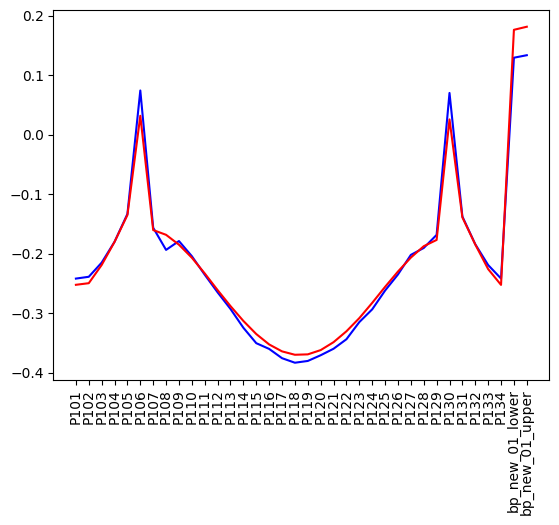

In [ ]:
time_desired = 100.0e-3
i_time = np.argmin(np.abs(gsfit_time - time_desired))

plt.figure()
i_sensors = list(range(34)) + [len(bp_probes_keys) - 2] + [len(bp_probes_keys) - 1]
plt.plot(
    [bp_probes_keys[i] for i in i_sensors],
    bp_probes_measured[i_time, i_sensors],
    color="blue",
)
plt.plot(
    [bp_probes_keys[i] for i in i_sensors],
    bp_probes_calculated[i_time, i_sensors],
    color="red",
)
plt.xticks(rotation=90);